# Machine Learning - Practical 4 - Deep Learning VS Trees


Names: {YOUR NAMES}  
Summer Term 2023   
Due Date: Tuesday, June 13, 2pm

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [2]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Load, clean and split the tabular dataset

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 20 items. 

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Data description:**  
Data reported to the police about the circumstances of personal injury road accidents in Great Britain from 1979. This version includes data up to 2015. We will try to predict the sex of the driver based on the data provided.

In [9]:
## In case you have any issues with loading the pickle file
## check that your pandas version is 1.4.1
## or just simply run:
## pip install pandas==1.4.1

with open('adopted_road_safety.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [10]:
dataset

,Accident_Index,Vehicle_Reference_df_res,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,201501BS70001,1,19.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,7.0,3,5.0,1.0,0.0,0.0,2.0,0,NaN,NaN
1,201501BS70002,1,9.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,5.0,3,9.0,9.0,0.0,0.0,2.0,0,1.0,3.0
2,201501BS70004,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,6.0,3,1.0,3.0,0.0,0.0,2.0,0,1.0,6.0
3,201501BS70005,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,2.0,3,5.0,1.0,0.0,0.0,2.0,0,1.0,2.0
4,201501BS70008,1,1.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,8.0,2,0.0,0.0,0.0,0.0,0.0,1,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363238,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,1.0,3,0.0,0.0,2.0,0.0,0.0,9,1.0,NaN
363239,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,5.0,3,0.0,0.0,0.0,0.0,0.0,9,1.0,2.0
363240,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,4.0,3,0.0,0.0,0.0,0.0,0.0,9,2.0,5.0
363241,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,6.0,3,0.0,0.0,0.0,0.0,0.0,9,3.0,NaN


In [11]:
target_column = 'Sex_of_Driver'
test_size = 0.2
random_state = 42

In [15]:
def remove_nans(df):
    '''
    This function removes rows with NaN values.
    '''

    # Drop rows with NaN values
    cleaned_df = df.dropna()  

    return cleaned_df


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    Change the type of the column to categorical 
    if it has <= n unique values.
    '''

    for column in df.columns:

        if column not in ignore:
            # Calculate the number of unique values in the column
            unique_values = df[column].nunique()  

            # Change column type to categorical if condition is met
            if unique_values <= n:
                df[column] = df[column].astype('category')  
        else:
            # If the column is in the ignore list, do nothing
            pass

    return df


def remove_columns_by_n(df, n=10, condition=np.number, direction='less', ignore=[target_column]):
    '''
    Remove columns with more or less than n unique values.
    Usually it makes sense to apply this function to columns with categorical values.
    With the default values, we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''

    # Iterate over each column in the DataFrame
    for column in df.columns:
        
        # Calculate number of unique values in current column
        n_unique = df[column].nunique()

        # Check if column should be ignored or is equal to target_column
        if column not in ignore:

            # Check direction parameter and compare unique value count with n
            if direction == 'less' and n_unique < n:
                df.drop(column, axis=1, inplace=True)
            
            elif direction == 'more' and n_unique > n:
                df.drop(column, axis=1, inplace=True)
        else:
            # If the column is in the ignore list, do nothing
            pass
        
    return df

In [16]:
df = dataset
df = remove_nans(df)
df = numerical_to_categorical(df, n=2, ignore=[target_column])
df = remove_columns_by_n(df, n=10, condition=np.number, direction='less', 
                         ignore=[target_column])
df = remove_columns_by_n(df, n=40, condition='category', direction='more', 
                         ignore=[target_column])
assert not df.isna().any().any(), 'There are still nans in the dataframe'

C:\Users\Paul\AppData\Local\Temp\ipykernel_13952\3719716334.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')
C:\Users\Paul\AppData\Local\Temp\ipykernel_13952\3719716334.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(column, axis=1, inplace=True)
C:\Users\Paul\AppData\Local\Temp\ipykernel_13952\3719716334.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [18]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y

# Split DataFrame into features (X) and target variable (Y)
X = df.drop(columns=[target_column])
Y = df[target_column]

# Perform train-test split
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)

**TODO :**  

* Did you split the dataset in a stratified manner or not? Why?
* How did the dataset dimensions change after preprocessing?
* How many unique values are in the response variable? 

## Task 1: Create a GradientBoostingClassifier

In [19]:
## TODO : define the GradientBoostingClassifier, 
## train it on the train set and predict on the test set

# Define GradientBoostingClassifier
model = GradientBoostingClassifier()

# Train the model on train set
model.fit(train_X, train_y)

# Make predictions on test set
predictions = model.predict(test_X)


In [30]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics

# Calculate accuracy
accuracy = accuracy_score(test_y, predictions)

# Calculate precision (change average parameter to 'micro', 'macro', or 'weighted')
precision = precision_score(test_y, predictions, average='weighted')

# Calculate recall (change average parameter to 'micro', 'macro', or 'weighted')
recall = recall_score(test_y, predictions, average='weighted')

# Print the scores
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.665161424270736
Precision: 0.6373300040935023
Recall: 0.665161424270736


In [ ]:
## TODO : Write a function which iterates over trees_amount, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    #TODO


In [ ]:
trees_amount_exploration(train_X, train_y, test_X, test_y)

In [ ]:
## TODO : Write a function which iterates over the learning rate, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    
    for lr in learning_rates:

        # Define the GradientBoostingClassifier with the specified number of trees
        model = GradientBoostingClassifier(learning_rate = lr, n_estimators = trees_amount)

        # Train the model on the training set
        model.fit(train_X, train_y)

        # Make predictions on the test set
        predictions = model.predict(test_X)

        # Calculate accuracy
        accuracy = accuracy_score(test_y, predictions)

        # Calculate precision
        precision = precision_score(test_y, predictions, average='weighted', zero_division=0)

        # Calculate recall
        recall = recall_score(test_y, predictions, average='weighted')

        # Print the scores
        print(f'Learning Rate: {lr}   ;   Number of Trees: {trees_amount}\n')
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}\n\n')

In [38]:
learning_rate_exploration(train_X, train_y, test_X, test_y)

Learning Rate: 0.1        ;        Number of Trees: 100

Number of Trees: 100
Accuracy: 0.665161424270736
Precision: 0.6373300040935023
Recall: 0.665161424270736


Learning Rate: 0.2        ;        Number of Trees: 100

Number of Trees: 100
Accuracy: 0.66578428319319
Precision: 0.6373593758333945
Recall: 0.66578428319319


Learning Rate: 0.3        ;        Number of Trees: 100

Number of Trees: 100
Accuracy: 0.6666666666666666
Precision: 0.6386029240478612
Recall: 0.6666666666666666


Learning Rate: 0.4        ;        Number of Trees: 100

Number of Trees: 100
Accuracy: 0.6669261912176891
Precision: 0.6398011175074222
Recall: 0.6669261912176891


Learning Rate: 0.5        ;        Number of Trees: 100

Number of Trees: 100
Accuracy: 0.6693657219973009
Precision: 0.6430827524968562
Recall: 0.6693657219973009




In [42]:
## TODO : Write a function which iterates over different depths, 
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1,2,3,4,5] , trees_amount = 50):
        
    for depth in depths:
        # Define the GradientBoostingClassifier with the specified depth and number of trees
        model = GradientBoostingClassifier(max_depth = depth, n_estimators = trees_amount)

        # Train the model on the training set
        model.fit(train_X, train_y)

        # Make predictions on the test set
        predictions = model.predict(test_X)

        # Calculate accuracy
        accuracy = accuracy_score(test_y, predictions)

        # Calculate precision
        precision = precision_score(test_y, predictions, average = 'weighted', zero_division = 0)

        # Calculate recall
        recall = recall_score(test_y, predictions, average='weighted')

        # Print the scores
        print(f"Depth: {depth}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print()

In [43]:
max_depth_exploration(train_X, train_y, test_X, test_y)

Depth: 1
Accuracy: 0.6515623377971557
Precision: 0.42453348003569474
Recall: 0.6515623377971557

Depth: 2
Accuracy: 0.6532232949236998
Precision: 0.6523570979929778
Recall: 0.6532232949236998

Depth: 3
Accuracy: 0.6591923595972179
Precision: 0.6312328904513802
Recall: 0.6591923595972179

Depth: 4
Accuracy: 0.6633447524135784
Precision: 0.6367317352928115
Recall: 0.6633447524135784

Depth: 5
Accuracy: 0.6671338108585072
Precision: 0.6421582962850476
Recall: 0.6671338108585072



**TODO :**   

* How does the max_depth parameter influence the results? 
* How does the learning rate influence the results?
* How does the number of trees in the ensemble influence the results?
* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?

In [53]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot

def plot_explained_variance(clf, X):
    # Get feature importances from the classifier
    importances = clf.feature_importances_

    # Get feature names from the feature matrix
    feature_names = X.columns

    # Sort feature importances in descending order
    sorted_indices = importances.argsort()[::-1]
    sorted_importances = importances[sorted_indices][::-1]
    sorted_feature_names = feature_names[sorted_indices][::-1]

    # Create a horizontal bar plot to show relative feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_feature_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

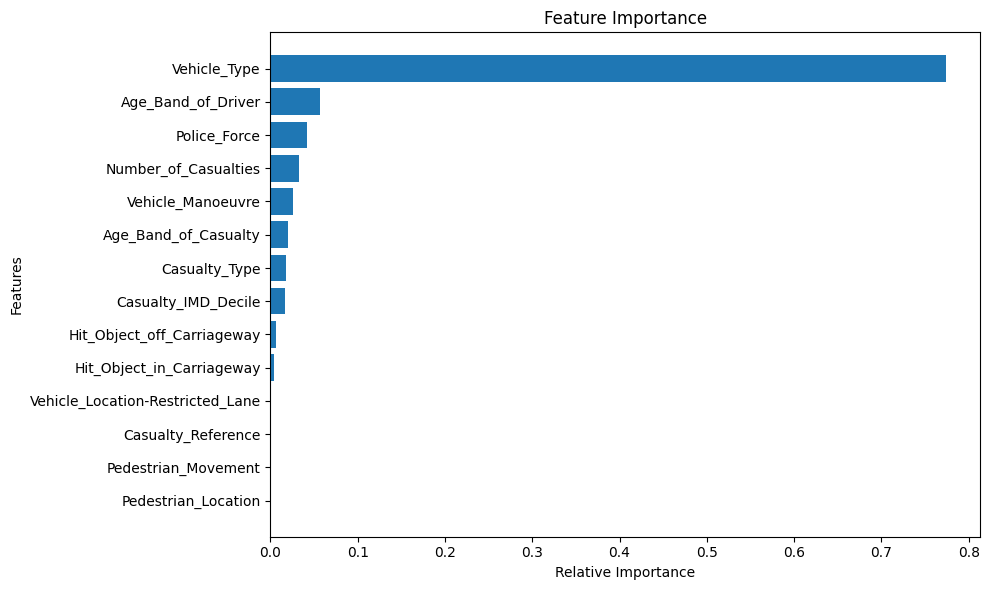

In [54]:
## TODO : display the plot
plot_explained_variance(model, train_X)

**TODO :** Interpret the plot.

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why? 

## Prepare for deep learning
### Add all the necessary training functions 
*You can reuse them from previous practical exercises*

In [ ]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3 

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    

In [ ]:
## TODO : Define a train and validation functions here
## Hint - you can use yours from practical 3 

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """
    # Todo


def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    # Todo

In [ ]:
#TODO write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO

In [ ]:
# TODO write a plot function 
## Hint - you can use yours from practical 2 or 3 


### Convert a pandas dataframe to a PyTorch dataset

In [ ]:
## TODO : Define the dataset, apply normalization in the getitem method
## Hint : you can use/adapt your code from practical 2
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes, 
        x is data without target column
        y is target column
        transform df to_numpy
        ''' 
        self.x = 
        self.y = 
        self.mean = 
        self.std = 
        self.normalise = 
    
    def __len__(self):
        # TODO: return the length of the whole dataset

    
    def __getitem__(self, index):
        ## TODO: return X, y by index, normalized if needed
        

In [ ]:
## TODO : calculate mean and std for the train set
## Hint : be careful with categorical values. Convert them them to numerical 
## Hint : the response variable should be of datatype integer


In [ ]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0!


## TODO : define dataloaders, with specified batch size and shuffled
batch_size = 256


## Logistic regression

In [ ]:
class LR(torch.nn.Module):
    """
    The logistic regression model inherits from torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO define linear layer for the model
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        x = x.to(torch.float32)
        # TODO run the data through the layer
        
        return outputs

In [ ]:
## TODO define model, loss and optimisers
## don't forget to move everything for the correct devices
## 
lr=0.001


In [ ]:
## TODO train the network
num_epochs = 30


In [ ]:
## todo - plot losses and accuracies
plot('Epoch vs. Loss', 'Loss', train_losses_lr, val_losses_lr)

In [ ]:
plot('Epoch vs. Accuracy', 'Accuracy', train_accs_lr, val_accs_lr)


## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?

In [ ]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            # TODO : define 3 linear layer with sizes 
            # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity
            
        )
      

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # TODO

In [ ]:
## TODO : define model, optimiser, cross entropy loss,
## put model to the device, and train mode
## you can optionally apply regularisation between 0.0005 and 0.005 
lr=0.001


In [ ]:
## TODO : Train model
num_epochs = 50


In [ ]:
# TODO plot losses
plot('Epoch vs. Loss', 'Loss', train_losses, val_losses)

In [ ]:
# TODO plot accuracies
plot('Epoch vs. Accuracy', 'Accuracy', train_accs, val_accs)

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why? 


## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimiser. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ 
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/